In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [12]:
seed = 42
batch_size = 128
num_epochs = 8
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.makedirs("models", exist_ok=True)

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),                  # converts to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # mean/std for MNIST
])

In [14]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


In [15]:
# split train -> train+val
val_size = 5000
train_size = len(train_dataset) - val_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [16]:
# ----------------- Model (small CNN) -----------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input 1x28x28
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 32x28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 64x28x28
        self.pool  = nn.MaxPool2d(2, 2)               # halves size
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)             # 64 x 14 x 14
        x = self.dropout(x)
        x = self.pool(x)             # 64 x 7 x 7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [18]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss / total, correct / total

def evaluate(loader):
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            loss_sum += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return loss_sum / total, correct / total

In [19]:
best_val_acc = 0.0
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step()
    print(f"Epoch {epoch:02d}  Train loss: {train_loss:.4f} acc: {train_acc:.4f}  |  Val loss: {val_loss:.4f} acc: {val_acc:.4f}")
    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "models/best_mnist_cnn.pt")

print(f"Best validation accuracy: {best_val_acc:.4f}")

Epoch 01  Train loss: 0.2062 acc: 0.9368  |  Val loss: 0.0706 acc: 0.9804
Epoch 02  Train loss: 0.0681 acc: 0.9794  |  Val loss: 0.0550 acc: 0.9852
Epoch 03  Train loss: 0.0521 acc: 0.9843  |  Val loss: 0.0452 acc: 0.9856
Epoch 04  Train loss: 0.0341 acc: 0.9892  |  Val loss: 0.0345 acc: 0.9894
Epoch 05  Train loss: 0.0300 acc: 0.9905  |  Val loss: 0.0392 acc: 0.9880
Epoch 06  Train loss: 0.0267 acc: 0.9919  |  Val loss: 0.0359 acc: 0.9896
Epoch 07  Train loss: 0.0212 acc: 0.9935  |  Val loss: 0.0353 acc: 0.9902
Epoch 08  Train loss: 0.0186 acc: 0.9941  |  Val loss: 0.0342 acc: 0.9894
Best validation accuracy: 0.9902


In [20]:
model.load_state_dict(torch.load("models/best_mnist_cnn.pt", map_location=device))
test_loss, test_acc = evaluate(test_loader)
print(f"Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}")

Test loss: 0.0234  Test accuracy: 0.9923


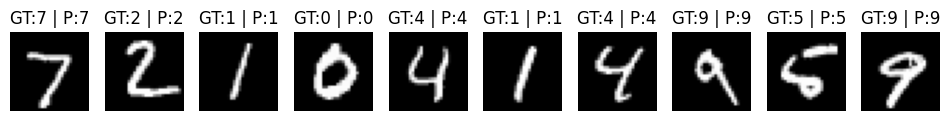

In [21]:
def show_predictions(n=8):
    model.eval()
    images = []
    labels = []
    preds = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            p = out.argmax(dim=1).cpu().numpy()
            images.extend(xb.cpu().numpy())
            labels.extend(yb.numpy())
            preds.extend(p)
            if len(images) >= n:
                break
    images = images[:n]
    labels = labels[:n]
    preds = preds[:n]

    plt.figure(figsize=(12, 3))
    for i in range(n):
        img = images[i].squeeze(0)  # 28x28
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"GT:{labels[i]} | P:{preds[i]}")
        plt.axis("off")
    plt.show()

show_predictions(10)